

# AMLS Assignment Draft
## Task B: CNN on BloodMNIST Dataset

Explore CNN based classifiers on the BloodMNIST dataset.

## Import libraries
The required libraries for this notebook are sklearn, copy, numpy and matplotlib.

In [8]:
## first enable autoreload during development so latest (new) version local code library is reloaded on execution 
## can be commented out when local code development not happening to avoid overhead
%load_ext autoreload
%autoreload 2

## import libraries
import io
import numpy as np
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

from tqdm import tqdm

class TqdmEpochProgress(tf.keras.callbacks.Callback):
    def __init__(self, total_epochs):
        super().__init__()
        self.total_epochs = total_epochs
        self.progress_bar = None

    def on_train_begin(self, logs=None):
        self.progress_bar = tqdm(total=self.total_epochs, desc="Epoch Progress", unit="epoch")

    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.update(1)
        self.progress_bar.set_postfix(logs)

    def on_train_end(self, logs=None):
        self.progress_bar.close()
        
## import tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy

## local code library
import AMLS_common as ac

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set base parameters
Including hyperparameters and environment specifics

In [9]:
## Initialize hyperparameters
parameter = ac.HyperParameters(learning_rate=0.001, 
                               batch_size=128, 
                               num_epochs=50, 
                               optimise="Adam",
                               loss="SparseCategoricalCrossentropy()",
                               default_activation="relu")

tqdm_callback = TqdmEpochProgress(total_epochs=parameter.num_epochs)

## use these lists to grid test hyper parameter sensitivity
epochs_list = [10,50,100,500]                 # number of epochs to be used
bs_list     = [32,64,128]                     # dataset batch size
lr_list     = [1, 0.1, 0.01, 0.001, 0.0001]   # learning rate

In [10]:
## control (e.g. verbose) parameters
filebase   = "metrics/"          ## place to save output files
verbose    = 1                   ## to control whether additional in process information is printed

## Load and preprocess the BloodMNIST Data
We load the dataset.

In [11]:
## Loading the data file using common MedMINST loader
data_flag  = 'bloodmnist'        # defines which dataset to load
result_set = ac.medMNIST_load(data_flag,parameter.batch_size)

## check that the loader returned data correctly and then split out
if result_set != []:
    train_dataset = result_set[0]
    test_dataset  = result_set[1]
    val_dataset   = result_set[2]

if verbose == 1:
    ## print summary stats for training dataset
    print("\nSummary metrics for train_dataset")
    print("type:",type(train_dataset))
    print("length:",len(train_dataset))
    print("shape:",train_dataset)

Using downloaded and verified file: C:\Users\johnc\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\johnc\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\johnc\.medmnist\bloodmnist.npz

Summary metrics for train_dataset
type: <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
length: 94
shape: <BatchDataset shapes: ((None, 28, 28, 3), (None, 1)), types: (tf.float64, tf.float32)>


## Define the CNN model

Define a base model

In [12]:
## Define the model
if verbose == 1:
    print("Default activation is ",parameter.default_activation)
    
model = Sequential([
    Conv2D(64, (3, 3), activation=parameter.default_activation, input_shape=(28, 28, 3)),   ## Input layer
    Conv2D(16, (3, 3), activation=parameter.default_activation),                            ## Convolution layer 
    MaxPooling2D((2, 2)),                                                                   ## Reduce the features
    Conv2D(16, (3, 3), activation=parameter.default_activation),                            ## Another Convolution layer 
    MaxPooling2D((2, 2)),                                                                   ## Again reduce the features
    Flatten(),                                                                              # Flatten
    Dropout(0.2),                                                                           # added dropout
    Dense(8, activation='softmax')                                                          # Output layer for 8 types 
])

print(model.summary())
## Redirect the summary output to a string
summary_string = io.StringIO()
model.summary(print_fn=lambda x: summary_string.write(x + "\n"))
summary_content = summary_string.getvalue()
summary_string.close()

optimizer_choice = str(parameter.optimise)+'(learning_rate='+str(parameter.learning_rate)+')'
optimizer        = eval(optimizer_choice)

## loss_choice      = 'tf.keras.losses.SparseCategoricalCrossentropy()'
## loss_choice      = 'tf.keras.losses.BinaryCrossentropy()'
## tf.keras.optimizers.Adam(learning_rate=0.001)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),                                                   
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics='acc')

Default activation is  relu
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 64)        1792      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 16)        9232      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dropout_1 (Dropout)       

## Fit the model

Fit using hyperparameters as defined above

50 128




Epoch Progress:   0%|          | 0/50 [00:00<?, ?epoch/s]

Epoch Progress:   2%|▏         | 1/50 [01:45<1:25:49, 105.09s/epoch]

Epoch Progress:   2%|▏         | 1/50 [01:45<1:25:49, 105.09s/epoch, loss=1.62, acc=0.382, val_loss=1.11, val_acc=0.645]

Epoch Progress:   4%|▍         | 2/50 [03:26<1:22:16, 102.85s/epoch, loss=1.62, acc=0.382, val_loss=1.11, val_acc=0.645]

Epoch Progress:   4%|▍         | 2/50 [03:26<1:22:16, 102.85s/epoch, loss=1.08, acc=0.594, val_loss=0.896, val_acc=0.69]

Epoch Progress:   6%|▌         | 3/50 [05:09<1:20:29, 102.76s/epoch, loss=1.08, acc=0.594, val_loss=0.896, val_acc=0.69]

Epoch Progress:   6%|▌         | 3/50 [05:09<1:20:29, 102.76s/epoch, loss=0.903, acc=0.671, val_loss=0.758, val_acc=0.732]

Epoch Progress:   8%|▊         | 4/50 [06:52<1:19:01, 103.07s/epoch, loss=0.903, acc=0.671, val_loss=0.758, val_acc=0.732]

Epoch Progress:   8%|▊         | 4/50 [06:52<1:19:01, 103.07s/epoch, loss=0.794, acc=0.718, val_loss=0.68, val_acc=0.759] 

Epoch Pro

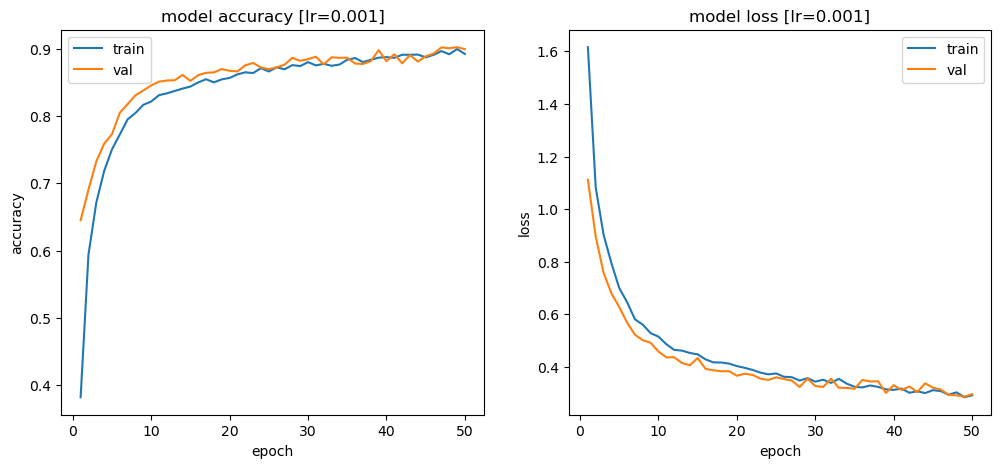

Item: loss
Item: acc
Item: val_loss
Item: val_acc
Files saved: ['metrics/metrics_2024_12_09_at_1506.xlsx', 'metrics/summary_2024_12_09_at_1506.txt']


In [15]:
## Fit the model
if verbose == 1:
    print(parameter.num_epochs,parameter.batch_size)
    
history = model.fit(train_dataset, 
                    validation_data=test_dataset, 
                    epochs=parameter.num_epochs, 
                    batch_size=parameter.batch_size, 
                    verbose=0,
                    callbacks = [tqdm_callback])

## output graphs and save metrics files
ac.graph_and_save(history,summary_content,parameter,filebase)